In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import math

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Base class for positional embeddings
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len
        
    def forward(self, x):
        """Add positional embeddings to the input tensor"""
        return x

# No positional embedding
class NoPositionalEmbedding(PositionalEmbedding):
    def __init__(self, d_model, max_len):
        super().__init__(d_model, max_len)
    
    def forward(self, x):
        # Return input as is (no positional information)
        return x

# 1D Learned positional embedding (default)
class Learned1DPositionalEmbedding(PositionalEmbedding):
    def __init__(self, d_model, max_len):
        super().__init__(d_model, max_len)
        self.pos_embedding = nn.Parameter(torch.zeros(1, max_len, d_model))
        self.init_weights()
    
    def init_weights(self):
        nn.init.normal_(self.pos_embedding, std=0.02)
    
    def forward(self, x):
        # Add learned 1D positional embedding to the input
        return x + self.pos_embedding[:, :x.size(1), :]

# 2D Learned positional embedding 
class Learned2DPositionalEmbedding(PositionalEmbedding):
    def __init__(self, d_model, max_len, grid_size):
        super().__init__(d_model, max_len)
        assert d_model % 2 == 0, "d_model must be even for 2D embeddings"
        self.grid_size = grid_size  # (H, W)
        # Create separate embeddings for X and Y dimensions
        self.pos_embedding_x = nn.Parameter(torch.zeros(1, grid_size[1], d_model // 2))
        self.pos_embedding_y = nn.Parameter(torch.zeros(1, grid_size[0], d_model // 2))
        self.cls_token_pos = nn.Parameter(torch.zeros(1, 1, d_model))
        self.init_weights()
    
    def init_weights(self):
        nn.init.normal_(self.pos_embedding_x, std=0.02)
        nn.init.normal_(self.pos_embedding_y, std=0.02)
        nn.init.normal_(self.cls_token_pos, std=0.02)
    
    def forward(self, x):
        # Special handling for cls token
        cls_token, patches = x[:, :1, :], x[:, 1:, :]
        
        # Reshape to [batch_size, H, W, dim]
        batch_size = patches.size(0)
        patches = patches.view(batch_size, self.grid_size[0], self.grid_size[1], -1)
        
        # Create 2D positional embeddings by concatenating X and Y embeddings
        pos_x = self.pos_embedding_x.expand(batch_size, -1, -1)  # [B, W, D/2]
        pos_y = self.pos_embedding_y.expand(batch_size, -1, -1)  # [B, H, D/2]
        
        # For each position (i,j), concatenate the embeddings
        pos_emb = torch.zeros(batch_size, self.grid_size[0], self.grid_size[1], self.d_model, device=x.device)
        
        for i in range(self.grid_size[0]):  # height
            for j in range(self.grid_size[1]):  # width
                pos_emb[:, i, j, :] = torch.cat([pos_y[:, i, :], pos_x[:, j, :]], dim=1)
        
        # Add positional embeddings to patches
        patches = patches + pos_emb
        
        # Reshape back to [batch_size, H*W, dim]
        patches = patches.view(batch_size, -1, self.d_model)
        
        # Add cls token back with its special position embedding
        cls_token = cls_token + self.cls_token_pos
        return torch.cat([cls_token, patches], dim=1)

# Sinusoidal positional embedding from "Attention Is All You Need"
class SinusoidalPositionalEmbedding(PositionalEmbedding):
    def __init__(self, d_model, max_len):
        super().__init__(d_model, max_len)
        
        # Create constant sinusoidal positional embeddings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))  # [1, max_len, d_model]
    
    def forward(self, x):
        # Add sinusoidal positional embeddings to the input
        return x + self.pe[:, :x.size(1), :]

class ScaledDotProductAttention(nn.Module):
    """Scaled Dot-Product Attention as described in the ViT paper"""
    def __init__(self, scale):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = scale
    
    def forward(self, q, k, v, mask=None):
        # q, k, v shape: [batch_size, head, seq_len, dim]
        # Calculate attention scores
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        
        # Apply mask if provided
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=-1)
        
        # Apply attention weights to values
        output = torch.matmul(attention_weights, v)
        
        return output, attention_weights

class MultiHeadAttention(nn.Module):
    """Multi-Head Attention as described in the ViT paper"""
    def __init__(self, dim_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.dim_model = dim_model
        
        assert dim_model % num_heads == 0, "dim_model must be divisible by num_heads"
        
        self.depth = dim_model // num_heads
        
        # Linear projections
        self.wq = nn.Linear(dim_model, dim_model)
        self.wk = nn.Linear(dim_model, dim_model)
        self.wv = nn.Linear(dim_model, dim_model)
        
        self.attention = ScaledDotProductAttention(scale=self.depth ** -0.5)
        
        self.fc_out = nn.Linear(dim_model, dim_model)
        
    def forward(self, q, k, v, mask=None):
        batch_size = q.shape[0]
        
        # Linear projections and reshape
        q = self.wq(q).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        k = self.wk(k).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        v = self.wv(v).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        
        # Scaled dot-product attention
        output, _ = self.attention(q, k, v, mask)
        
        # Reshape back and project
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.dim_model)
        output = self.fc_out(output)
        
        return output

class TransformerEncoderLayer(nn.Module):
    """Transformer Encoder Layer as described in the ViT paper"""
    def __init__(self, dim_model, num_heads, dim_ff, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.norm1 = nn.LayerNorm(dim_model)
        self.norm2 = nn.LayerNorm(dim_model)
        self.mha = MultiHeadAttention(dim_model, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(dim_model, dim_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_ff, dim_model),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Layer norm and multi-head attention (Pre-LN architecture)
        attn_output = self.mha(self.norm1(x), self.norm1(x), self.norm1(x), mask)
        # Residual connection
        x = x + self.dropout(attn_output)
        
        # Layer norm and feed forward
        ff_output = self.ffn(self.norm2(x))
        # Residual connection
        x = x + ff_output
        
        return x

class VisionTransformer(nn.Module):
    """Vision Transformer with customizable positional embedding types"""
    def __init__(self, 
                 image_size=32,        # CIFAR-10 image size
                 patch_size=4,         # as specified
                 in_channels=3,        # RGB images
                 num_classes=10,       # CIFAR-10 has 10 classes
                 dim_model=192,        # embedding dimension
                 num_heads=8,          # number of heads in multihead attention
                 num_encoder_layers=8, # number of transformer encoder layers
                 dim_ff=768,           # feed-forward network dimension
                 dropout=0.1,
                 pos_embedding_type='1d_learned'):  # type of positional embedding
        super(VisionTransformer, self).__init__()
        
        # Image and patch parameters
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        
        # Calculate the number of patches
        assert image_size % patch_size == 0, "Image size must be divisible by patch size"
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size
        
        # Grid size (height, width) of patches
        grid_size = (image_size // patch_size, image_size // patch_size)
        
        # Linear projection of flattened patches
        self.patch_embedding = nn.Linear(patch_dim, dim_model)
        
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim_model))
        
        # Positional embedding based on type
        if pos_embedding_type == 'none':
            self.pos_embedding = NoPositionalEmbedding(dim_model, num_patches + 1)
        elif pos_embedding_type == '1d_learned':
            self.pos_embedding = Learned1DPositionalEmbedding(dim_model, num_patches + 1)
        elif pos_embedding_type == '2d_learned':
            self.pos_embedding = Learned2DPositionalEmbedding(dim_model, num_patches + 1, grid_size)
        elif pos_embedding_type == 'sinusoidal':
            self.pos_embedding = SinusoidalPositionalEmbedding(dim_model, num_patches + 1)
        else:
            raise ValueError(f"Unknown positional embedding type: {pos_embedding_type}")
        
        # Dropout after position embedding
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(dim_model, num_heads, dim_ff, dropout)
            for _ in range(num_encoder_layers)
        ])
        
        # Layer normalization
        self.ln = nn.LayerNorm(dim_model)
        
        # MLP Head for classification
        self.mlp_head = nn.Linear(dim_model, num_classes)
        
        # Initialize weights
        self.init_weights()
        
    def init_weights(self):
        # Initialize patch embedding like a linear layer
        nn.init.xavier_uniform_(self.patch_embedding.weight)
        nn.init.zeros_(self.patch_embedding.bias)
        
        # Initialize cls token
        nn.init.xavier_normal_(self.cls_token)
        
    def forward(self, x):
        # x shape: [batch_size, channels, height, width]
        batch_size = x.shape[0]
        
        # Extract patches: [B, C, H, W] -> [B, num_patches, C*P*P]
        # Where P is the patch size
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(batch_size, self.in_channels, -1, self.patch_size * self.patch_size)
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.in_channels * self.patch_size * self.patch_size)
        
        # Linear embedding of patches
        x = self.patch_embedding(x)  # [B, num_patches, dim_model]
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [B, 1, dim_model]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, 1+num_patches, dim_model]
        
        # Add positional embedding
        x = self.pos_embedding(x)
        x = self.dropout(x)
        
        # Apply transformer encoder layers
        for layer in self.encoder_layers:
            x = layer(x)
        
        # Apply layer normalization
        x = self.ln(x)
        
        # Take the cls token representation
        x = x[:, 0]  # [B, dim_model]
        
        # Classification head
        x = self.mlp_head(x)  # [B, num_classes]
        
        return x
from torchvision.transforms import RandAugment

def get_data_loaders(batch_size=128):
    """Create CIFAR-10 dataloaders"""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        RandAugment(num_ops=2, magnitude=9),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Create a validation set
    val_size = 5000
    train_size = len(trainset) - val_size
    
    train_subset, val_subset = torch.utils.data.random_split(
        trainset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(42))
    
    valloader = DataLoader(
        val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    train_subset_loader = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    return train_subset_loader, valloader, testloader

def train_model(model, train_loader, val_loader, epochs=30, lr=3e-4, weight_decay=1e-4, model_save_path='best_vit_model.pth'):
    """Train the Vision Transformer model"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # For tracking metrics
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    # For saving the best model
    best_val_acc = 0
    best_model_path = model_save_path
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({
                'loss': train_loss/(batch_idx+1), 
                'acc': 100.*correct/total
            })
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                pbar.set_postfix({
                    'loss': val_loss/(batch_idx+1), 
                    'acc': 100.*correct/total
                })
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Print stats
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        
        # Save the best model
        if val_acc > best_val_acc:
            print(f'Validation accuracy improved from {best_val_acc:.2f}% to {val_acc:.2f}%, saving model...')
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
        
        # Update learning rate
        scheduler.step()
    
    print(f'Best validation accuracy: {best_val_acc:.2f}%')
    return train_losses, train_accs, val_losses, val_accs

def evaluate_model(model, test_loader, model_path=None):
    """Evaluate the trained model on the test set"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if model_path:
        model.load_state_dict(torch.load(model_path))
    
    model = model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Evaluating on test set'):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_acc = 100. * correct / total
    print(f'Test accuracy: {test_acc:.2f}%')
    return test_acc

def plot_metrics(train_losses, val_losses, train_accs, val_accs, title_suffix="", filename_prefix="vit"):
    """Plot loss and accuracy curves separately with custom titles and filenames"""
    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss {title_suffix}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{filename_prefix}_loss_curves.png')
    plt.show()
    
    # Plot accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Training and Validation Accuracy {title_suffix}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{filename_prefix}_accuracy_curves.png')
    plt.show()



def compare_positional_embeddings():
    """Compare different positional embedding types"""
    pos_embedding_types = ['none', '1d_learned', '2d_learned', 'sinusoidal']
    results = {}
    
    # Store training stats for later comparison
    all_training_stats = {}
    
    # Hyperparameters
    batch_size = 128
    epochs = 50
    lr = 3e-4
    weight_decay = 1e-4
    
    # Get data loaders
    train_loader, val_loader, test_loader = get_data_loaders(batch_size)
    
    for pos_type in pos_embedding_types:
        print(f"\n\n{'='*50}")
        print(f"Testing positional embedding type: {pos_type}")
        print(f"{'='*50}\n")
        
        # Create model with the current positional embedding type
        model = VisionTransformer(
            image_size=32, patch_size=4, in_channels=3, num_classes=10,
            dim_model=192, num_heads=8, num_encoder_layers=8, dim_ff=768, 
            dropout=0.1, pos_embedding_type=pos_type
        )
        
        model_save_path = f'best_vit_model_{pos_type}.pth'
        
        # Train model
        train_losses, train_accs, val_losses, val_accs = train_model(
            model, train_loader, val_loader, epochs=epochs, lr=lr, 
            weight_decay=weight_decay, model_save_path=model_save_path
        )
        
        # Store training stats for this model
        all_training_stats[pos_type] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs
        }
        
        # Load best model and evaluate
        best_model = VisionTransformer(
            image_size=32, patch_size=4, in_channels=3, num_classes=10,
            dim_model=192, num_heads=8, num_encoder_layers=8, dim_ff=768, 
            dropout=0.1, pos_embedding_type=pos_type
        )
        test_acc = evaluate_model(best_model, test_loader, model_path=model_save_path)
        results[pos_type] = test_acc
        
        # Plot metrics
        plot_metrics(
            train_losses, val_losses, train_accs, val_accs,
            title_suffix=f" - {pos_type} Positional Embedding", 
            filename_prefix=f"vit_{pos_type}"
        )
    
    # Print and plot results summary
    print("\n\nPositional Embedding Results Summary:")
    print("-" * 50)
    for pos_type, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"{pos_type.ljust(15)}: {acc:.2f}%")
    
    # Plot bar chart of results
    plt.figure(figsize=(12, 6))
    plt.bar(results.keys(), results.values())
    plt.xlabel('Positional Embedding Type')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Effect of Different Positional Embeddings on Test Accuracy')
    plt.ylim(bottom=max(0, min(results.values()) - 5))  # Better visualization
    plt.savefig('positional_embedding_comparison.png')
    plt.show()
    
    # Plot all loss curves together
    plt.figure(figsize=(12, 6))
    for pos_type in pos_embedding_types:
        # Use the stored training stats directly instead of loading from file
        plt.plot(all_training_stats[pos_type]['val_losses'], label=pos_type)
    
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Across Different Positional Embeddings')
    plt.legend()
    plt.grid(True)
    plt.savefig('all_pos_embedding_loss_comparison.png')
    plt.show()
    
    return results


100%|██████████| 170M/170M [00:11<00:00, 14.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Testing positional embedding type: none

Using device: cuda


Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.32it/s, loss=1.74, acc=36.2]


Epoch 1/50:
Train Loss: 1.9514 | Train Acc: 26.96%
Val Loss: 1.7423 | Val Acc: 36.16%
Validation accuracy improved from 0.00% to 36.16%, saving model...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.93it/s, loss=1.62, acc=40.3]


Epoch 2/50:
Train Loss: 1.6763 | Train Acc: 38.60%
Val Loss: 1.6231 | Val Acc: 40.32%
Validation accuracy improved from 36.16% to 40.32%, saving model...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.44it/s, loss=1.51, acc=45]


Epoch 3/50:
Train Loss: 1.5521 | Train Acc: 43.40%
Val Loss: 1.5139 | Val Acc: 44.98%
Validation accuracy improved from 40.32% to 44.98%, saving model...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.77it/s, loss=1.43, acc=49.3]


Epoch 4/50:
Train Loss: 1.4655 | Train Acc: 47.02%
Val Loss: 1.4257 | Val Acc: 49.26%
Validation accuracy improved from 44.98% to 49.26%, saving model...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.21it/s, loss=1.41, acc=49.5]


Epoch 5/50:
Train Loss: 1.4131 | Train Acc: 48.62%
Val Loss: 1.4137 | Val Acc: 49.48%
Validation accuracy improved from 49.26% to 49.48%, saving model...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.44it/s, loss=1.35, acc=51.2]


Epoch 6/50:
Train Loss: 1.3672 | Train Acc: 50.32%
Val Loss: 1.3493 | Val Acc: 51.24%
Validation accuracy improved from 49.48% to 51.24%, saving model...


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.61it/s, loss=1.32, acc=51.1]


Epoch 7/50:
Train Loss: 1.3291 | Train Acc: 52.20%
Val Loss: 1.3225 | Val Acc: 51.10%


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.03it/s, loss=1.31, acc=53.2]


Epoch 8/50:
Train Loss: 1.2874 | Train Acc: 53.82%
Val Loss: 1.3080 | Val Acc: 53.24%
Validation accuracy improved from 51.24% to 53.24%, saving model...


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.98it/s, loss=1.21, acc=56.3]


Epoch 9/50:
Train Loss: 1.2610 | Train Acc: 55.07%
Val Loss: 1.2128 | Val Acc: 56.28%
Validation accuracy improved from 53.24% to 56.28%, saving model...


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.00it/s, loss=1.18, acc=57.5]


Epoch 10/50:
Train Loss: 1.2363 | Train Acc: 55.84%
Val Loss: 1.1825 | Val Acc: 57.48%
Validation accuracy improved from 56.28% to 57.48%, saving model...


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.72it/s, loss=1.19, acc=57.5]


Epoch 11/50:
Train Loss: 1.2091 | Train Acc: 56.73%
Val Loss: 1.1938 | Val Acc: 57.48%


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.47it/s, loss=1.16, acc=58.4]


Epoch 12/50:
Train Loss: 1.1833 | Train Acc: 57.82%
Val Loss: 1.1644 | Val Acc: 58.40%
Validation accuracy improved from 57.48% to 58.40%, saving model...


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.51it/s, loss=1.14, acc=59.3]


Epoch 13/50:
Train Loss: 1.1534 | Train Acc: 58.83%
Val Loss: 1.1441 | Val Acc: 59.34%
Validation accuracy improved from 58.40% to 59.34%, saving model...


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.16it/s, loss=1.11, acc=59.5]


Epoch 14/50:
Train Loss: 1.1345 | Train Acc: 59.34%
Val Loss: 1.1112 | Val Acc: 59.50%
Validation accuracy improved from 59.34% to 59.50%, saving model...


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.03it/s, loss=1.13, acc=60.1]


Epoch 15/50:
Train Loss: 1.1173 | Train Acc: 60.00%
Val Loss: 1.1288 | Val Acc: 60.12%
Validation accuracy improved from 59.50% to 60.12%, saving model...


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.31it/s, loss=1.1, acc=60.9]


Epoch 16/50:
Train Loss: 1.1014 | Train Acc: 60.83%
Val Loss: 1.0973 | Val Acc: 60.92%
Validation accuracy improved from 60.12% to 60.92%, saving model...


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.03it/s, loss=1.05, acc=62.5]


Epoch 17/50:
Train Loss: 1.0726 | Train Acc: 61.67%
Val Loss: 1.0469 | Val Acc: 62.52%
Validation accuracy improved from 60.92% to 62.52%, saving model...


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.28it/s, loss=1.05, acc=62.3]


Epoch 18/50:
Train Loss: 1.0487 | Train Acc: 62.61%
Val Loss: 1.0520 | Val Acc: 62.34%


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.50it/s, loss=1.02, acc=63.8]


Epoch 19/50:
Train Loss: 1.0414 | Train Acc: 62.95%
Val Loss: 1.0156 | Val Acc: 63.82%
Validation accuracy improved from 62.52% to 63.82%, saving model...


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.25it/s, loss=1.02, acc=63.2]


Epoch 20/50:
Train Loss: 1.0191 | Train Acc: 63.55%
Val Loss: 1.0168 | Val Acc: 63.16%


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.05it/s, loss=1.01, acc=63.7]


Epoch 21/50:
Train Loss: 1.0051 | Train Acc: 64.41%
Val Loss: 1.0088 | Val Acc: 63.66%


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.65it/s, loss=1.01, acc=64.4]


Epoch 22/50:
Train Loss: 0.9852 | Train Acc: 65.03%
Val Loss: 1.0145 | Val Acc: 64.44%
Validation accuracy improved from 63.82% to 64.44%, saving model...


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.39it/s, loss=0.974, acc=65]


Epoch 23/50:
Train Loss: 0.9681 | Train Acc: 65.53%
Val Loss: 0.9739 | Val Acc: 65.02%
Validation accuracy improved from 64.44% to 65.02%, saving model...


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.35it/s, loss=0.957, acc=66.2]


Epoch 24/50:
Train Loss: 0.9529 | Train Acc: 65.91%
Val Loss: 0.9566 | Val Acc: 66.16%
Validation accuracy improved from 65.02% to 66.16%, saving model...


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.41it/s, loss=0.963, acc=66]


Epoch 25/50:
Train Loss: 0.9377 | Train Acc: 66.75%
Val Loss: 0.9631 | Val Acc: 66.02%


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.59it/s, loss=0.967, acc=65.9]


Epoch 26/50:
Train Loss: 0.9258 | Train Acc: 67.06%
Val Loss: 0.9670 | Val Acc: 65.92%


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.43it/s, loss=0.933, acc=66.4]


Epoch 27/50:
Train Loss: 0.9054 | Train Acc: 67.64%
Val Loss: 0.9333 | Val Acc: 66.38%
Validation accuracy improved from 66.16% to 66.38%, saving model...


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.29it/s, loss=0.92, acc=67.3]


Epoch 28/50:
Train Loss: 0.8945 | Train Acc: 67.94%
Val Loss: 0.9198 | Val Acc: 67.32%
Validation accuracy improved from 66.38% to 67.32%, saving model...


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.94it/s, loss=0.949, acc=66.9]


Epoch 29/50:
Train Loss: 0.8707 | Train Acc: 69.11%
Val Loss: 0.9494 | Val Acc: 66.92%


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.51it/s, loss=0.928, acc=67]


Epoch 30/50:
Train Loss: 0.8643 | Train Acc: 69.22%
Val Loss: 0.9279 | Val Acc: 66.96%


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.05it/s, loss=0.909, acc=67.8]


Epoch 31/50:
Train Loss: 0.8526 | Train Acc: 69.64%
Val Loss: 0.9089 | Val Acc: 67.78%
Validation accuracy improved from 67.32% to 67.78%, saving model...


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.66it/s, loss=0.888, acc=69.1]


Epoch 32/50:
Train Loss: 0.8360 | Train Acc: 70.08%
Val Loss: 0.8878 | Val Acc: 69.06%
Validation accuracy improved from 67.78% to 69.06%, saving model...


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.24it/s, loss=0.886, acc=69]


Epoch 33/50:
Train Loss: 0.8310 | Train Acc: 70.34%
Val Loss: 0.8858 | Val Acc: 68.96%


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.48it/s, loss=0.897, acc=68.4]


Epoch 34/50:
Train Loss: 0.8119 | Train Acc: 71.12%
Val Loss: 0.8973 | Val Acc: 68.40%


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.95it/s, loss=0.89, acc=68.7]


Epoch 35/50:
Train Loss: 0.8060 | Train Acc: 71.46%
Val Loss: 0.8896 | Val Acc: 68.68%


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.26it/s, loss=0.869, acc=70.1]


Epoch 36/50:
Train Loss: 0.7941 | Train Acc: 71.86%
Val Loss: 0.8691 | Val Acc: 70.06%
Validation accuracy improved from 69.06% to 70.06%, saving model...


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.84it/s, loss=0.875, acc=68.8]


Epoch 37/50:
Train Loss: 0.7855 | Train Acc: 71.97%
Val Loss: 0.8750 | Val Acc: 68.78%


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.26it/s, loss=0.893, acc=68.8]


Epoch 38/50:
Train Loss: 0.7777 | Train Acc: 72.37%
Val Loss: 0.8929 | Val Acc: 68.76%


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.70it/s, loss=0.864, acc=69.9]


Epoch 39/50:
Train Loss: 0.7616 | Train Acc: 73.03%
Val Loss: 0.8644 | Val Acc: 69.90%


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.32it/s, loss=0.855, acc=70.4]


Epoch 40/50:
Train Loss: 0.7529 | Train Acc: 73.36%
Val Loss: 0.8552 | Val Acc: 70.36%
Validation accuracy improved from 70.06% to 70.36%, saving model...


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.69it/s, loss=0.857, acc=70.3]


Epoch 41/50:
Train Loss: 0.7564 | Train Acc: 73.02%
Val Loss: 0.8569 | Val Acc: 70.26%


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.73it/s, loss=0.861, acc=71.3]


Epoch 42/50:
Train Loss: 0.7451 | Train Acc: 73.53%
Val Loss: 0.8607 | Val Acc: 71.30%
Validation accuracy improved from 70.36% to 71.30%, saving model...


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.08it/s, loss=0.867, acc=69.7]


Epoch 43/50:
Train Loss: 0.7328 | Train Acc: 73.84%
Val Loss: 0.8672 | Val Acc: 69.66%


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.34it/s, loss=0.863, acc=70.3]


Epoch 44/50:
Train Loss: 0.7384 | Train Acc: 74.08%
Val Loss: 0.8632 | Val Acc: 70.34%


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.28it/s, loss=0.843, acc=69.8]


Epoch 45/50:
Train Loss: 0.7294 | Train Acc: 74.02%
Val Loss: 0.8429 | Val Acc: 69.82%


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.26it/s, loss=0.857, acc=70.3]


Epoch 46/50:
Train Loss: 0.7274 | Train Acc: 74.08%
Val Loss: 0.8568 | Val Acc: 70.30%


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.23it/s, loss=0.839, acc=70.7]


Epoch 47/50:
Train Loss: 0.7226 | Train Acc: 74.04%
Val Loss: 0.8389 | Val Acc: 70.74%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.60it/s, loss=0.85, acc=70.4]


Epoch 48/50:
Train Loss: 0.7245 | Train Acc: 74.33%
Val Loss: 0.8496 | Val Acc: 70.38%


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.93it/s, loss=0.85, acc=70.3]


Epoch 49/50:
Train Loss: 0.7182 | Train Acc: 74.53%
Val Loss: 0.8501 | Val Acc: 70.28%


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.47it/s, loss=0.859, acc=69.8]
/tmp/ipykernel_19/3483036.py:461: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mode

Epoch 50/50:
Train Loss: 0.7175 | Train Acc: 74.52%
Val Loss: 0.8588 | Val Acc: 69.84%
Best validation accuracy: 71.30%


Evaluating on test set: 100%|██████████| 79/79 [00:01<00:00, 40.06it/s]


Test accuracy: 74.78%


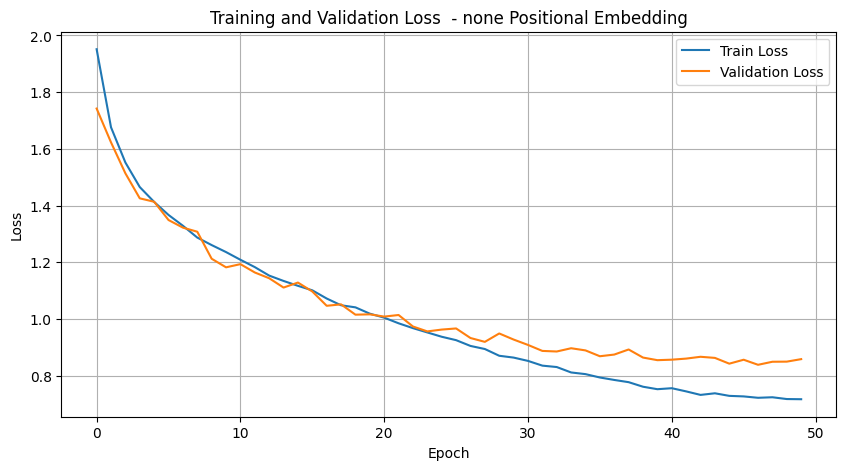

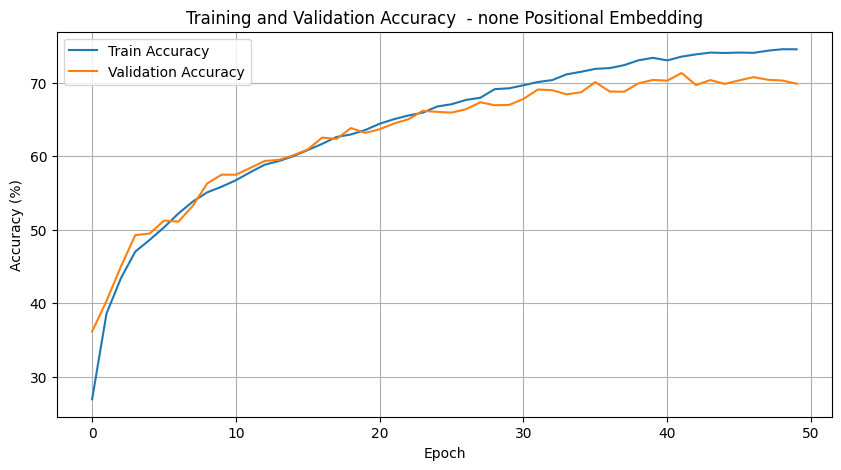



Testing positional embedding type: 1d_learned

Using device: cuda


Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.36it/s, loss=1.76, acc=35.2]


Epoch 1/50:
Train Loss: 1.9329 | Train Acc: 27.62%
Val Loss: 1.7552 | Val Acc: 35.18%
Validation accuracy improved from 0.00% to 35.18%, saving model...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.73it/s, loss=1.55, acc=43]


Epoch 2/50:
Train Loss: 1.6619 | Train Acc: 38.97%
Val Loss: 1.5489 | Val Acc: 42.98%
Validation accuracy improved from 35.18% to 42.98%, saving model...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.51it/s, loss=1.5, acc=47.1]


Epoch 3/50:
Train Loss: 1.5213 | Train Acc: 44.48%
Val Loss: 1.4950 | Val Acc: 47.14%
Validation accuracy improved from 42.98% to 47.14%, saving model...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.67it/s, loss=1.36, acc=50.5]


Epoch 4/50:
Train Loss: 1.4255 | Train Acc: 48.34%
Val Loss: 1.3618 | Val Acc: 50.54%
Validation accuracy improved from 47.14% to 50.54%, saving model...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.63it/s, loss=1.3, acc=52.3]


Epoch 5/50:
Train Loss: 1.3555 | Train Acc: 50.81%
Val Loss: 1.2988 | Val Acc: 52.30%
Validation accuracy improved from 50.54% to 52.30%, saving model...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.30it/s, loss=1.26, acc=54.5]


Epoch 6/50:
Train Loss: 1.2870 | Train Acc: 53.91%
Val Loss: 1.2564 | Val Acc: 54.46%
Validation accuracy improved from 52.30% to 54.46%, saving model...


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.26it/s, loss=1.23, acc=55.8]


Epoch 7/50:
Train Loss: 1.2447 | Train Acc: 55.36%
Val Loss: 1.2262 | Val Acc: 55.76%
Validation accuracy improved from 54.46% to 55.76%, saving model...


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.59it/s, loss=1.13, acc=59.7]


Epoch 8/50:
Train Loss: 1.1980 | Train Acc: 57.14%
Val Loss: 1.1269 | Val Acc: 59.74%
Validation accuracy improved from 55.76% to 59.74%, saving model...


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.55it/s, loss=1.12, acc=59.7]


Epoch 9/50:
Train Loss: 1.1541 | Train Acc: 58.92%
Val Loss: 1.1213 | Val Acc: 59.72%


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.47it/s, loss=1.11, acc=59.4]


Epoch 10/50:
Train Loss: 1.1216 | Train Acc: 59.74%
Val Loss: 1.1096 | Val Acc: 59.44%


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.18it/s, loss=1.08, acc=62]


Epoch 11/50:
Train Loss: 1.0837 | Train Acc: 61.27%
Val Loss: 1.0775 | Val Acc: 62.00%
Validation accuracy improved from 59.74% to 62.00%, saving model...


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.08it/s, loss=1.02, acc=63.6]


Epoch 12/50:
Train Loss: 1.0446 | Train Acc: 62.70%
Val Loss: 1.0150 | Val Acc: 63.56%
Validation accuracy improved from 62.00% to 63.56%, saving model...


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.10it/s, loss=0.987, acc=64.6]


Epoch 13/50:
Train Loss: 1.0184 | Train Acc: 63.72%
Val Loss: 0.9865 | Val Acc: 64.58%
Validation accuracy improved from 63.56% to 64.58%, saving model...


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.83it/s, loss=1, acc=63.9]


Epoch 14/50:
Train Loss: 0.9943 | Train Acc: 64.72%
Val Loss: 1.0022 | Val Acc: 63.90%


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.75it/s, loss=0.938, acc=66.6]


Epoch 15/50:
Train Loss: 0.9690 | Train Acc: 65.42%
Val Loss: 0.9382 | Val Acc: 66.56%
Validation accuracy improved from 64.58% to 66.56%, saving model...


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.52it/s, loss=0.934, acc=66.7]


Epoch 16/50:
Train Loss: 0.9443 | Train Acc: 66.52%
Val Loss: 0.9337 | Val Acc: 66.66%
Validation accuracy improved from 66.56% to 66.66%, saving model...


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.78it/s, loss=0.9, acc=67.8]


Epoch 17/50:
Train Loss: 0.9182 | Train Acc: 67.57%
Val Loss: 0.9005 | Val Acc: 67.78%
Validation accuracy improved from 66.66% to 67.78%, saving model...


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.77it/s, loss=0.911, acc=68]


Epoch 18/50:
Train Loss: 0.8972 | Train Acc: 68.23%
Val Loss: 0.9113 | Val Acc: 67.98%
Validation accuracy improved from 67.78% to 67.98%, saving model...


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.89it/s, loss=0.87, acc=69.6]


Epoch 19/50:
Train Loss: 0.8801 | Train Acc: 68.92%
Val Loss: 0.8698 | Val Acc: 69.58%
Validation accuracy improved from 67.98% to 69.58%, saving model...


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.71it/s, loss=0.856, acc=69.4]


Epoch 20/50:
Train Loss: 0.8558 | Train Acc: 69.68%
Val Loss: 0.8556 | Val Acc: 69.42%


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.26it/s, loss=0.833, acc=69.1]


Epoch 21/50:
Train Loss: 0.8371 | Train Acc: 70.50%
Val Loss: 0.8334 | Val Acc: 69.06%


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.97it/s, loss=0.85, acc=69.5]


Epoch 22/50:
Train Loss: 0.8186 | Train Acc: 70.79%
Val Loss: 0.8498 | Val Acc: 69.48%


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.30it/s, loss=0.825, acc=71.2]


Epoch 23/50:
Train Loss: 0.7964 | Train Acc: 71.97%
Val Loss: 0.8246 | Val Acc: 71.20%
Validation accuracy improved from 69.58% to 71.20%, saving model...


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.39it/s, loss=0.826, acc=70.8]


Epoch 24/50:
Train Loss: 0.7848 | Train Acc: 72.21%
Val Loss: 0.8257 | Val Acc: 70.84%


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.39it/s, loss=0.844, acc=71]


Epoch 25/50:
Train Loss: 0.7700 | Train Acc: 72.96%
Val Loss: 0.8436 | Val Acc: 71.04%


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.97it/s, loss=0.787, acc=71.7]


Epoch 26/50:
Train Loss: 0.7574 | Train Acc: 73.02%
Val Loss: 0.7872 | Val Acc: 71.68%
Validation accuracy improved from 71.20% to 71.68%, saving model...


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.01it/s, loss=0.788, acc=72.3]


Epoch 27/50:
Train Loss: 0.7309 | Train Acc: 74.15%
Val Loss: 0.7875 | Val Acc: 72.26%
Validation accuracy improved from 71.68% to 72.26%, saving model...


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.53it/s, loss=0.746, acc=74.2]


Epoch 28/50:
Train Loss: 0.7160 | Train Acc: 74.72%
Val Loss: 0.7463 | Val Acc: 74.22%
Validation accuracy improved from 72.26% to 74.22%, saving model...


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.69it/s, loss=0.777, acc=72.5]


Epoch 29/50:
Train Loss: 0.7023 | Train Acc: 75.08%
Val Loss: 0.7772 | Val Acc: 72.52%


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.21it/s, loss=0.795, acc=72.3]


Epoch 30/50:
Train Loss: 0.6873 | Train Acc: 75.66%
Val Loss: 0.7946 | Val Acc: 72.34%


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.56it/s, loss=0.744, acc=73.9]


Epoch 31/50:
Train Loss: 0.6836 | Train Acc: 75.76%
Val Loss: 0.7441 | Val Acc: 73.88%


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.61it/s, loss=0.729, acc=74.3]


Epoch 32/50:
Train Loss: 0.6709 | Train Acc: 76.37%
Val Loss: 0.7291 | Val Acc: 74.28%
Validation accuracy improved from 74.22% to 74.28%, saving model...


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.52it/s, loss=0.721, acc=74.6]


Epoch 33/50:
Train Loss: 0.6593 | Train Acc: 76.68%
Val Loss: 0.7211 | Val Acc: 74.64%
Validation accuracy improved from 74.28% to 74.64%, saving model...


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.66it/s, loss=0.743, acc=74.9]


Epoch 34/50:
Train Loss: 0.6400 | Train Acc: 77.31%
Val Loss: 0.7429 | Val Acc: 74.90%
Validation accuracy improved from 74.64% to 74.90%, saving model...


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.17it/s, loss=0.718, acc=75.4]


Epoch 35/50:
Train Loss: 0.6249 | Train Acc: 77.93%
Val Loss: 0.7180 | Val Acc: 75.40%
Validation accuracy improved from 74.90% to 75.40%, saving model...


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.29it/s, loss=0.724, acc=75]


Epoch 36/50:
Train Loss: 0.6219 | Train Acc: 78.05%
Val Loss: 0.7243 | Val Acc: 75.00%


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.33it/s, loss=0.683, acc=76.1]


Epoch 37/50:
Train Loss: 0.6109 | Train Acc: 78.42%
Val Loss: 0.6830 | Val Acc: 76.14%
Validation accuracy improved from 75.40% to 76.14%, saving model...


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.53it/s, loss=0.696, acc=75.7]


Epoch 38/50:
Train Loss: 0.6072 | Train Acc: 78.44%
Val Loss: 0.6964 | Val Acc: 75.70%


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.55it/s, loss=0.684, acc=76.4]


Epoch 39/50:
Train Loss: 0.5993 | Train Acc: 78.83%
Val Loss: 0.6836 | Val Acc: 76.42%
Validation accuracy improved from 76.14% to 76.42%, saving model...


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.73it/s, loss=0.689, acc=75.8]


Epoch 40/50:
Train Loss: 0.5877 | Train Acc: 79.20%
Val Loss: 0.6891 | Val Acc: 75.84%


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.96it/s, loss=0.683, acc=76.2]


Epoch 41/50:
Train Loss: 0.5750 | Train Acc: 79.59%
Val Loss: 0.6829 | Val Acc: 76.22%


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.33it/s, loss=0.665, acc=76.8]


Epoch 42/50:
Train Loss: 0.5717 | Train Acc: 79.65%
Val Loss: 0.6653 | Val Acc: 76.78%
Validation accuracy improved from 76.42% to 76.78%, saving model...


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.16it/s, loss=0.692, acc=76.1]


Epoch 43/50:
Train Loss: 0.5679 | Train Acc: 79.96%
Val Loss: 0.6920 | Val Acc: 76.12%


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.06it/s, loss=0.714, acc=76.1]


Epoch 44/50:
Train Loss: 0.5582 | Train Acc: 80.17%
Val Loss: 0.7142 | Val Acc: 76.06%


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.13it/s, loss=0.697, acc=76.4]


Epoch 45/50:
Train Loss: 0.5559 | Train Acc: 80.21%
Val Loss: 0.6969 | Val Acc: 76.40%


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.59it/s, loss=0.685, acc=76.4]


Epoch 46/50:
Train Loss: 0.5509 | Train Acc: 80.68%
Val Loss: 0.6851 | Val Acc: 76.44%


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.41it/s, loss=0.691, acc=76.7]


Epoch 47/50:
Train Loss: 0.5513 | Train Acc: 80.54%
Val Loss: 0.6905 | Val Acc: 76.74%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.85it/s, loss=0.699, acc=76]


Epoch 48/50:
Train Loss: 0.5521 | Train Acc: 80.37%
Val Loss: 0.6987 | Val Acc: 76.02%


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.50it/s, loss=0.662, acc=76.4]


Epoch 49/50:
Train Loss: 0.5485 | Train Acc: 80.28%
Val Loss: 0.6624 | Val Acc: 76.44%


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.25it/s, loss=0.7, acc=75.7]


Epoch 50/50:
Train Loss: 0.5493 | Train Acc: 80.62%
Val Loss: 0.7004 | Val Acc: 75.70%
Best validation accuracy: 76.78%


Evaluating on test set: 100%|██████████| 79/79 [00:01<00:00, 40.45it/s]


Test accuracy: 81.23%


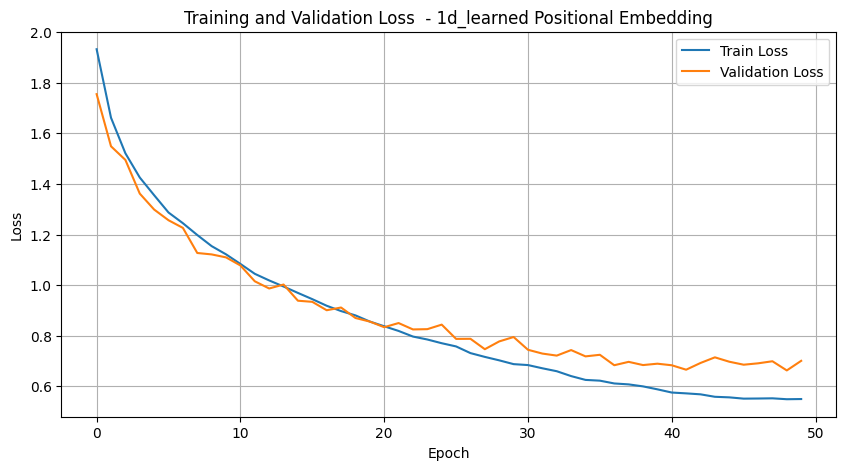

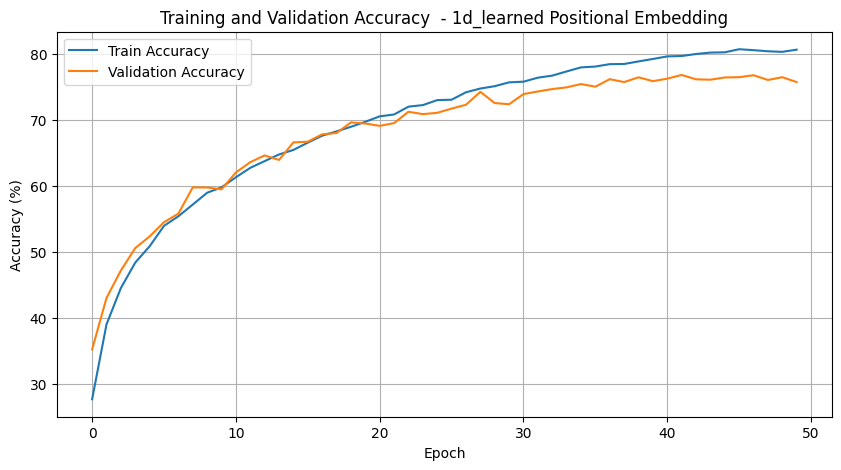



Testing positional embedding type: 2d_learned

Using device: cuda


Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.84it/s, loss=1.76, acc=35.3]


Epoch 1/50:
Train Loss: 1.9429 | Train Acc: 27.40%
Val Loss: 1.7569 | Val Acc: 35.30%
Validation accuracy improved from 0.00% to 35.30%, saving model...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.82it/s, loss=1.56, acc=42.6]


Epoch 2/50:
Train Loss: 1.6523 | Train Acc: 39.23%
Val Loss: 1.5603 | Val Acc: 42.64%
Validation accuracy improved from 35.30% to 42.64%, saving model...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.12it/s, loss=1.39, acc=49.3]


Epoch 3/50:
Train Loss: 1.4894 | Train Acc: 45.90%
Val Loss: 1.3891 | Val Acc: 49.28%
Validation accuracy improved from 42.64% to 49.28%, saving model...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.65it/s, loss=1.33, acc=50.8]


Epoch 4/50:
Train Loss: 1.3906 | Train Acc: 49.50%
Val Loss: 1.3347 | Val Acc: 50.82%
Validation accuracy improved from 49.28% to 50.82%, saving model...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.25it/s, loss=1.26, acc=55.3]


Epoch 5/50:
Train Loss: 1.3184 | Train Acc: 52.19%
Val Loss: 1.2575 | Val Acc: 55.34%
Validation accuracy improved from 50.82% to 55.34%, saving model...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.99it/s, loss=1.19, acc=56.6]


Epoch 6/50:
Train Loss: 1.2572 | Train Acc: 54.59%
Val Loss: 1.1940 | Val Acc: 56.64%
Validation accuracy improved from 55.34% to 56.64%, saving model...


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.39it/s, loss=1.16, acc=58.4]


Epoch 7/50:
Train Loss: 1.2042 | Train Acc: 57.06%
Val Loss: 1.1623 | Val Acc: 58.42%
Validation accuracy improved from 56.64% to 58.42%, saving model...


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.81it/s, loss=1.13, acc=58.9]


Epoch 8/50:
Train Loss: 1.1653 | Train Acc: 58.23%
Val Loss: 1.1269 | Val Acc: 58.92%
Validation accuracy improved from 58.42% to 58.92%, saving model...


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.38it/s, loss=1.07, acc=61.3]


Epoch 9/50:
Train Loss: 1.1152 | Train Acc: 60.19%
Val Loss: 1.0730 | Val Acc: 61.32%
Validation accuracy improved from 58.92% to 61.32%, saving model...


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.42it/s, loss=1.06, acc=62.1]


Epoch 10/50:
Train Loss: 1.0814 | Train Acc: 61.66%
Val Loss: 1.0589 | Val Acc: 62.10%
Validation accuracy improved from 61.32% to 62.10%, saving model...


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.52it/s, loss=1.02, acc=63.3]


Epoch 11/50:
Train Loss: 1.0429 | Train Acc: 62.92%
Val Loss: 1.0160 | Val Acc: 63.30%
Validation accuracy improved from 62.10% to 63.30%, saving model...


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.37it/s, loss=0.969, acc=65.3]


Epoch 12/50:
Train Loss: 1.0099 | Train Acc: 64.39%
Val Loss: 0.9694 | Val Acc: 65.28%
Validation accuracy improved from 63.30% to 65.28%, saving model...


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.33it/s, loss=1, acc=64.8]


Epoch 13/50:
Train Loss: 0.9824 | Train Acc: 65.47%
Val Loss: 1.0035 | Val Acc: 64.76%


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.05it/s, loss=0.921, acc=67]


Epoch 14/50:
Train Loss: 0.9555 | Train Acc: 65.95%
Val Loss: 0.9212 | Val Acc: 67.02%
Validation accuracy improved from 65.28% to 67.02%, saving model...


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.39it/s, loss=0.916, acc=67.4]


Epoch 15/50:
Train Loss: 0.9356 | Train Acc: 66.73%
Val Loss: 0.9157 | Val Acc: 67.44%
Validation accuracy improved from 67.02% to 67.44%, saving model...


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.47it/s, loss=0.889, acc=68.2]


Epoch 16/50:
Train Loss: 0.9081 | Train Acc: 67.86%
Val Loss: 0.8887 | Val Acc: 68.20%
Validation accuracy improved from 67.44% to 68.20%, saving model...


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.28it/s, loss=0.889, acc=68.6]


Epoch 17/50:
Train Loss: 0.8884 | Train Acc: 68.57%
Val Loss: 0.8892 | Val Acc: 68.60%
Validation accuracy improved from 68.20% to 68.60%, saving model...


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.31it/s, loss=0.851, acc=69.9]


Epoch 18/50:
Train Loss: 0.8629 | Train Acc: 69.63%
Val Loss: 0.8508 | Val Acc: 69.92%
Validation accuracy improved from 68.60% to 69.92%, saving model...


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.09it/s, loss=0.818, acc=70.6]


Epoch 19/50:
Train Loss: 0.8378 | Train Acc: 70.42%
Val Loss: 0.8179 | Val Acc: 70.60%
Validation accuracy improved from 69.92% to 70.60%, saving model...


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 13.43it/s, loss=0.815, acc=71]


Epoch 20/50:
Train Loss: 0.8291 | Train Acc: 70.80%
Val Loss: 0.8151 | Val Acc: 71.00%
Validation accuracy improved from 70.60% to 71.00%, saving model...


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 13.90it/s, loss=0.834, acc=70.2]


Epoch 21/50:
Train Loss: 0.8079 | Train Acc: 71.49%
Val Loss: 0.8340 | Val Acc: 70.24%


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.12it/s, loss=0.817, acc=70.5]


Epoch 22/50:
Train Loss: 0.7815 | Train Acc: 72.50%
Val Loss: 0.8168 | Val Acc: 70.50%


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.25it/s, loss=0.791, acc=72.2]


Epoch 23/50:
Train Loss: 0.7700 | Train Acc: 72.73%
Val Loss: 0.7908 | Val Acc: 72.18%
Validation accuracy improved from 71.00% to 72.18%, saving model...


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.17it/s, loss=0.793, acc=72.2]


Epoch 24/50:
Train Loss: 0.7589 | Train Acc: 72.96%
Val Loss: 0.7927 | Val Acc: 72.20%
Validation accuracy improved from 72.18% to 72.20%, saving model...


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.17it/s, loss=0.769, acc=73]


Epoch 25/50:
Train Loss: 0.7440 | Train Acc: 73.92%
Val Loss: 0.7691 | Val Acc: 73.02%
Validation accuracy improved from 72.20% to 73.02%, saving model...


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 13.36it/s, loss=0.745, acc=74.7]


Epoch 26/50:
Train Loss: 0.7308 | Train Acc: 74.43%
Val Loss: 0.7446 | Val Acc: 74.66%
Validation accuracy improved from 73.02% to 74.66%, saving model...


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.67it/s, loss=0.788, acc=72.8]


Epoch 27/50:
Train Loss: 0.7152 | Train Acc: 74.90%
Val Loss: 0.7885 | Val Acc: 72.84%


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.23it/s, loss=0.753, acc=74]


Epoch 28/50:
Train Loss: 0.6984 | Train Acc: 75.46%
Val Loss: 0.7530 | Val Acc: 74.02%


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.33it/s, loss=0.766, acc=72.9]


Epoch 29/50:
Train Loss: 0.6818 | Train Acc: 76.00%
Val Loss: 0.7663 | Val Acc: 72.92%


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.33it/s, loss=0.743, acc=74.5]


Epoch 30/50:
Train Loss: 0.6700 | Train Acc: 76.50%
Val Loss: 0.7426 | Val Acc: 74.54%


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.90it/s, loss=0.726, acc=74.7]


Epoch 31/50:
Train Loss: 0.6568 | Train Acc: 76.92%
Val Loss: 0.7261 | Val Acc: 74.70%
Validation accuracy improved from 74.66% to 74.70%, saving model...


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.55it/s, loss=0.735, acc=74.5]


Epoch 32/50:
Train Loss: 0.6471 | Train Acc: 77.07%
Val Loss: 0.7350 | Val Acc: 74.46%


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.35it/s, loss=0.709, acc=75.1]


Epoch 33/50:
Train Loss: 0.6327 | Train Acc: 77.65%
Val Loss: 0.7095 | Val Acc: 75.12%
Validation accuracy improved from 74.70% to 75.12%, saving model...


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.32it/s, loss=0.697, acc=76.3]


Epoch 34/50:
Train Loss: 0.6141 | Train Acc: 78.38%
Val Loss: 0.6972 | Val Acc: 76.26%
Validation accuracy improved from 75.12% to 76.26%, saving model...


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.64it/s, loss=0.713, acc=75.2]


Epoch 35/50:
Train Loss: 0.6098 | Train Acc: 78.40%
Val Loss: 0.7133 | Val Acc: 75.16%


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.34it/s, loss=0.664, acc=77.1]


Epoch 36/50:
Train Loss: 0.6017 | Train Acc: 78.85%
Val Loss: 0.6636 | Val Acc: 77.14%
Validation accuracy improved from 76.26% to 77.14%, saving model...


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.22it/s, loss=0.705, acc=76]


Epoch 37/50:
Train Loss: 0.5841 | Train Acc: 79.45%
Val Loss: 0.7054 | Val Acc: 76.02%


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.55it/s, loss=0.703, acc=75.9]


Epoch 38/50:
Train Loss: 0.5838 | Train Acc: 79.39%
Val Loss: 0.7031 | Val Acc: 75.94%


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.34it/s, loss=0.683, acc=76.8]


Epoch 39/50:
Train Loss: 0.5751 | Train Acc: 79.50%
Val Loss: 0.6830 | Val Acc: 76.80%


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.91it/s, loss=0.671, acc=76.6]


Epoch 40/50:
Train Loss: 0.5601 | Train Acc: 80.32%
Val Loss: 0.6712 | Val Acc: 76.60%


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.10it/s, loss=0.672, acc=76.9]


Epoch 41/50:
Train Loss: 0.5569 | Train Acc: 80.32%
Val Loss: 0.6720 | Val Acc: 76.90%


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.51it/s, loss=0.681, acc=77]


Epoch 42/50:
Train Loss: 0.5532 | Train Acc: 80.38%
Val Loss: 0.6811 | Val Acc: 76.98%


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.00it/s, loss=0.667, acc=77.3]


Epoch 43/50:
Train Loss: 0.5434 | Train Acc: 80.82%
Val Loss: 0.6671 | Val Acc: 77.34%
Validation accuracy improved from 77.14% to 77.34%, saving model...


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.24it/s, loss=0.679, acc=76.7]


Epoch 44/50:
Train Loss: 0.5448 | Train Acc: 80.78%
Val Loss: 0.6793 | Val Acc: 76.66%


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.02it/s, loss=0.662, acc=77.7]


Epoch 45/50:
Train Loss: 0.5338 | Train Acc: 81.15%
Val Loss: 0.6621 | Val Acc: 77.66%
Validation accuracy improved from 77.34% to 77.66%, saving model...


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.36it/s, loss=0.659, acc=77.6]


Epoch 46/50:
Train Loss: 0.5385 | Train Acc: 80.77%
Val Loss: 0.6590 | Val Acc: 77.56%


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.88it/s, loss=0.67, acc=77.3]


Epoch 47/50:
Train Loss: 0.5320 | Train Acc: 81.16%
Val Loss: 0.6697 | Val Acc: 77.34%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.39it/s, loss=0.669, acc=77.4]


Epoch 48/50:
Train Loss: 0.5284 | Train Acc: 81.38%
Val Loss: 0.6687 | Val Acc: 77.36%


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.98it/s, loss=0.653, acc=77.9]


Epoch 49/50:
Train Loss: 0.5312 | Train Acc: 81.19%
Val Loss: 0.6529 | Val Acc: 77.92%
Validation accuracy improved from 77.66% to 77.92%, saving model...


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.23it/s, loss=0.659, acc=76.7]


Epoch 50/50:
Train Loss: 0.5302 | Train Acc: 81.18%
Val Loss: 0.6589 | Val Acc: 76.72%
Best validation accuracy: 77.92%


Evaluating on test set: 100%|██████████| 79/79 [00:02<00:00, 33.93it/s]


Test accuracy: 82.02%


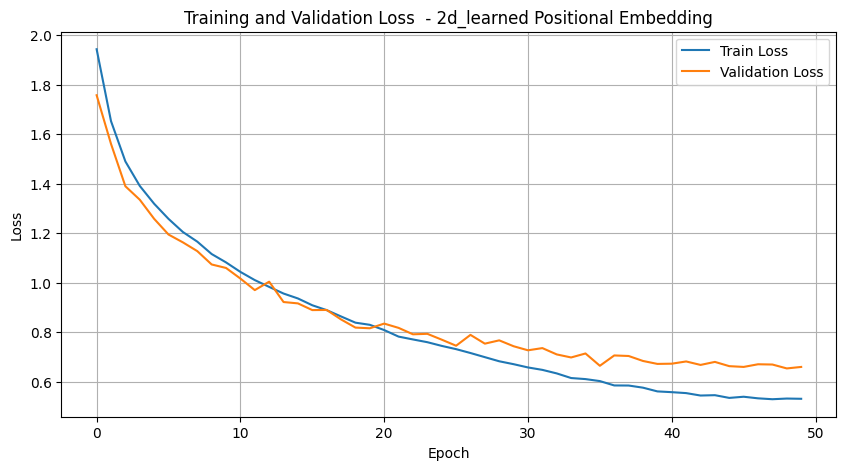

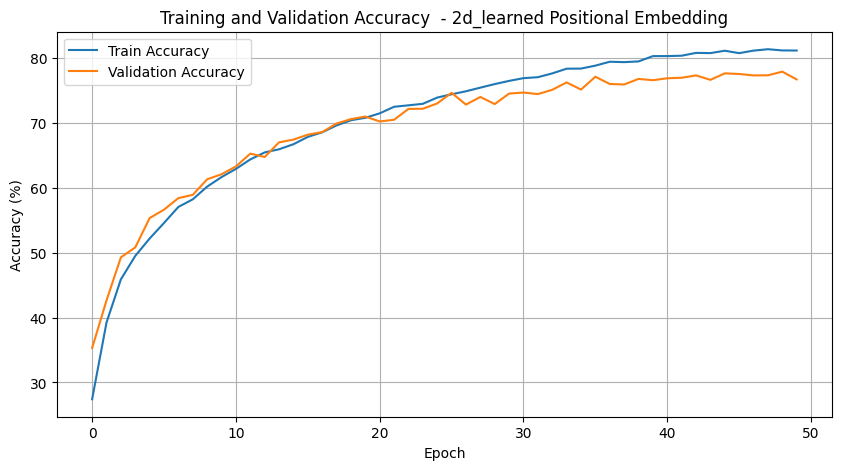



Testing positional embedding type: sinusoidal

Using device: cuda


Epoch 1/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.76it/s, loss=1.77, acc=35]


Epoch 1/50:
Train Loss: 1.9606 | Train Acc: 26.82%
Val Loss: 1.7700 | Val Acc: 34.96%
Validation accuracy improved from 0.00% to 34.96%, saving model...


Epoch 2/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.23it/s, loss=1.54, acc=44.6]


Epoch 2/50:
Train Loss: 1.6500 | Train Acc: 39.57%
Val Loss: 1.5431 | Val Acc: 44.62%
Validation accuracy improved from 34.96% to 44.62%, saving model...


Epoch 3/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.84it/s, loss=1.38, acc=49.5]


Epoch 3/50:
Train Loss: 1.5017 | Train Acc: 45.42%
Val Loss: 1.3813 | Val Acc: 49.50%
Validation accuracy improved from 44.62% to 49.50%, saving model...


Epoch 4/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.63it/s, loss=1.33, acc=51.3]


Epoch 4/50:
Train Loss: 1.4105 | Train Acc: 49.08%
Val Loss: 1.3337 | Val Acc: 51.32%
Validation accuracy improved from 49.50% to 51.32%, saving model...


Epoch 5/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.80it/s, loss=1.28, acc=53.3]


Epoch 5/50:
Train Loss: 1.3428 | Train Acc: 51.05%
Val Loss: 1.2769 | Val Acc: 53.34%
Validation accuracy improved from 51.32% to 53.34%, saving model...


Epoch 6/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.89it/s, loss=1.24, acc=54.9]


Epoch 6/50:
Train Loss: 1.2898 | Train Acc: 53.62%
Val Loss: 1.2409 | Val Acc: 54.88%
Validation accuracy improved from 53.34% to 54.88%, saving model...


Epoch 7/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.26it/s, loss=1.18, acc=56.5]


Epoch 7/50:
Train Loss: 1.2476 | Train Acc: 55.16%
Val Loss: 1.1796 | Val Acc: 56.50%
Validation accuracy improved from 54.88% to 56.50%, saving model...


Epoch 8/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.80it/s, loss=1.18, acc=59]


Epoch 8/50:
Train Loss: 1.2057 | Train Acc: 56.56%
Val Loss: 1.1807 | Val Acc: 58.98%
Validation accuracy improved from 56.50% to 58.98%, saving model...


Epoch 9/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.25it/s, loss=1.14, acc=59.5]


Epoch 9/50:
Train Loss: 1.1628 | Train Acc: 58.30%
Val Loss: 1.1387 | Val Acc: 59.50%
Validation accuracy improved from 58.98% to 59.50%, saving model...


Epoch 10/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.06it/s, loss=1.1, acc=59.8]


Epoch 10/50:
Train Loss: 1.1278 | Train Acc: 59.71%
Val Loss: 1.1048 | Val Acc: 59.80%
Validation accuracy improved from 59.50% to 59.80%, saving model...


Epoch 11/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.48it/s, loss=1.07, acc=61.6]


Epoch 11/50:
Train Loss: 1.0972 | Train Acc: 61.08%
Val Loss: 1.0661 | Val Acc: 61.56%
Validation accuracy improved from 59.80% to 61.56%, saving model...


Epoch 12/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.02it/s, loss=1.05, acc=62.4]


Epoch 12/50:
Train Loss: 1.0678 | Train Acc: 62.07%
Val Loss: 1.0521 | Val Acc: 62.40%
Validation accuracy improved from 61.56% to 62.40%, saving model...


Epoch 13/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.19it/s, loss=1.05, acc=62.3]


Epoch 13/50:
Train Loss: 1.0359 | Train Acc: 63.04%
Val Loss: 1.0451 | Val Acc: 62.28%


Epoch 14/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.54it/s, loss=1.05, acc=63.2]


Epoch 14/50:
Train Loss: 1.0116 | Train Acc: 63.92%
Val Loss: 1.0495 | Val Acc: 63.22%
Validation accuracy improved from 62.40% to 63.22%, saving model...


Epoch 15/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.27it/s, loss=0.99, acc=66]


Epoch 15/50:
Train Loss: 0.9797 | Train Acc: 65.16%
Val Loss: 0.9899 | Val Acc: 66.02%
Validation accuracy improved from 63.22% to 66.02%, saving model...


Epoch 16/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.59it/s, loss=0.943, acc=66.7]


Epoch 16/50:
Train Loss: 0.9572 | Train Acc: 66.03%
Val Loss: 0.9434 | Val Acc: 66.72%
Validation accuracy improved from 66.02% to 66.72%, saving model...


Epoch 17/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.22it/s, loss=0.928, acc=66.3]


Epoch 17/50:
Train Loss: 0.9263 | Train Acc: 67.18%
Val Loss: 0.9282 | Val Acc: 66.30%


Epoch 18/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.66it/s, loss=0.898, acc=68.5]


Epoch 18/50:
Train Loss: 0.9002 | Train Acc: 68.04%
Val Loss: 0.8979 | Val Acc: 68.46%
Validation accuracy improved from 66.72% to 68.46%, saving model...


Epoch 19/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.29it/s, loss=0.907, acc=67.6]


Epoch 19/50:
Train Loss: 0.8869 | Train Acc: 68.67%
Val Loss: 0.9074 | Val Acc: 67.58%


Epoch 20/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.60it/s, loss=0.856, acc=69.6]


Epoch 20/50:
Train Loss: 0.8670 | Train Acc: 69.32%
Val Loss: 0.8563 | Val Acc: 69.64%
Validation accuracy improved from 68.46% to 69.64%, saving model...


Epoch 21/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.37it/s, loss=0.85, acc=69.9]


Epoch 21/50:
Train Loss: 0.8426 | Train Acc: 70.25%
Val Loss: 0.8497 | Val Acc: 69.92%
Validation accuracy improved from 69.64% to 69.92%, saving model...


Epoch 22/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.82it/s, loss=0.852, acc=69.9]


Epoch 22/50:
Train Loss: 0.8300 | Train Acc: 70.68%
Val Loss: 0.8524 | Val Acc: 69.92%


Epoch 23/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.55it/s, loss=0.834, acc=70.7]


Epoch 23/50:
Train Loss: 0.8085 | Train Acc: 71.74%
Val Loss: 0.8343 | Val Acc: 70.72%
Validation accuracy improved from 69.92% to 70.72%, saving model...


Epoch 24/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.93it/s, loss=0.821, acc=71]


Epoch 24/50:
Train Loss: 0.7970 | Train Acc: 71.79%
Val Loss: 0.8215 | Val Acc: 71.02%
Validation accuracy improved from 70.72% to 71.02%, saving model...


Epoch 25/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.40it/s, loss=0.846, acc=70.4]


Epoch 25/50:
Train Loss: 0.7698 | Train Acc: 72.82%
Val Loss: 0.8460 | Val Acc: 70.44%


Epoch 26/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.72it/s, loss=0.835, acc=71.1]


Epoch 26/50:
Train Loss: 0.7619 | Train Acc: 73.04%
Val Loss: 0.8355 | Val Acc: 71.12%
Validation accuracy improved from 71.02% to 71.12%, saving model...


Epoch 27/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.39it/s, loss=0.815, acc=72.3]


Epoch 27/50:
Train Loss: 0.7418 | Train Acc: 73.77%
Val Loss: 0.8146 | Val Acc: 72.28%
Validation accuracy improved from 71.12% to 72.28%, saving model...


Epoch 28/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.84it/s, loss=0.811, acc=72.5]


Epoch 28/50:
Train Loss: 0.7322 | Train Acc: 74.09%
Val Loss: 0.8113 | Val Acc: 72.50%
Validation accuracy improved from 72.28% to 72.50%, saving model...


Epoch 29/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.39it/s, loss=0.791, acc=72]


Epoch 29/50:
Train Loss: 0.7119 | Train Acc: 74.91%
Val Loss: 0.7910 | Val Acc: 72.00%


Epoch 30/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.76it/s, loss=0.776, acc=73.8]


Epoch 30/50:
Train Loss: 0.7061 | Train Acc: 75.05%
Val Loss: 0.7763 | Val Acc: 73.82%
Validation accuracy improved from 72.50% to 73.82%, saving model...


Epoch 31/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.68it/s, loss=0.778, acc=73.1]


Epoch 31/50:
Train Loss: 0.6901 | Train Acc: 75.69%
Val Loss: 0.7781 | Val Acc: 73.06%


Epoch 32/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.33it/s, loss=0.799, acc=72.8]


Epoch 32/50:
Train Loss: 0.6809 | Train Acc: 75.83%
Val Loss: 0.7992 | Val Acc: 72.82%


Epoch 33/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.08it/s, loss=0.756, acc=74.9]


Epoch 33/50:
Train Loss: 0.6631 | Train Acc: 76.55%
Val Loss: 0.7564 | Val Acc: 74.86%
Validation accuracy improved from 73.82% to 74.86%, saving model...


Epoch 34/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.51it/s, loss=0.742, acc=74.6]


Epoch 34/50:
Train Loss: 0.6526 | Train Acc: 76.90%
Val Loss: 0.7422 | Val Acc: 74.58%


Epoch 35/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.93it/s, loss=0.788, acc=72.8]


Epoch 35/50:
Train Loss: 0.6426 | Train Acc: 77.29%
Val Loss: 0.7879 | Val Acc: 72.76%


Epoch 36/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.26it/s, loss=0.752, acc=74]


Epoch 36/50:
Train Loss: 0.6350 | Train Acc: 77.51%
Val Loss: 0.7522 | Val Acc: 74.04%


Epoch 37/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.56it/s, loss=0.72, acc=75]


Epoch 37/50:
Train Loss: 0.6290 | Train Acc: 77.57%
Val Loss: 0.7201 | Val Acc: 75.02%
Validation accuracy improved from 74.86% to 75.02%, saving model...


Epoch 38/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.06it/s, loss=0.71, acc=75.8]


Epoch 38/50:
Train Loss: 0.6114 | Train Acc: 78.36%
Val Loss: 0.7096 | Val Acc: 75.84%
Validation accuracy improved from 75.02% to 75.84%, saving model...


Epoch 39/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.14it/s, loss=0.726, acc=74.8]


Epoch 39/50:
Train Loss: 0.6121 | Train Acc: 78.35%
Val Loss: 0.7257 | Val Acc: 74.78%


Epoch 40/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.19it/s, loss=0.727, acc=74.4]


Epoch 40/50:
Train Loss: 0.5968 | Train Acc: 78.90%
Val Loss: 0.7268 | Val Acc: 74.42%


Epoch 41/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.15it/s, loss=0.709, acc=75.3]


Epoch 41/50:
Train Loss: 0.5938 | Train Acc: 78.93%
Val Loss: 0.7094 | Val Acc: 75.28%


Epoch 42/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 14.34it/s, loss=0.717, acc=75.5]


Epoch 42/50:
Train Loss: 0.5838 | Train Acc: 79.31%
Val Loss: 0.7172 | Val Acc: 75.50%


Epoch 43/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.80it/s, loss=0.695, acc=75.6]


Epoch 43/50:
Train Loss: 0.5762 | Train Acc: 79.75%
Val Loss: 0.6954 | Val Acc: 75.64%


Epoch 44/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.21it/s, loss=0.712, acc=75.7]


Epoch 44/50:
Train Loss: 0.5768 | Train Acc: 79.48%
Val Loss: 0.7120 | Val Acc: 75.74%


Epoch 45/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.65it/s, loss=0.706, acc=75.8]


Epoch 45/50:
Train Loss: 0.5732 | Train Acc: 79.60%
Val Loss: 0.7063 | Val Acc: 75.76%


Epoch 46/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.22it/s, loss=0.718, acc=75.6]


Epoch 46/50:
Train Loss: 0.5684 | Train Acc: 79.85%
Val Loss: 0.7179 | Val Acc: 75.56%


Epoch 47/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.63it/s, loss=0.699, acc=75.6]


Epoch 47/50:
Train Loss: 0.5685 | Train Acc: 79.82%
Val Loss: 0.6993 | Val Acc: 75.58%


Epoch 48/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.91it/s, loss=0.704, acc=76]


Epoch 48/50:
Train Loss: 0.5682 | Train Acc: 79.91%
Val Loss: 0.7044 | Val Acc: 76.02%
Validation accuracy improved from 75.84% to 76.02%, saving model...


Epoch 49/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 15.48it/s, loss=0.677, acc=76.3]


Epoch 49/50:
Train Loss: 0.5653 | Train Acc: 80.21%
Val Loss: 0.6771 | Val Acc: 76.30%
Validation accuracy improved from 76.02% to 76.30%, saving model...


Epoch 50/50 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.58it/s, loss=0.71, acc=76.1]


Epoch 50/50:
Train Loss: 0.5670 | Train Acc: 79.84%
Val Loss: 0.7097 | Val Acc: 76.10%
Best validation accuracy: 76.30%


Evaluating on test set: 100%|██████████| 79/79 [00:01<00:00, 40.45it/s]


Test accuracy: 81.06%


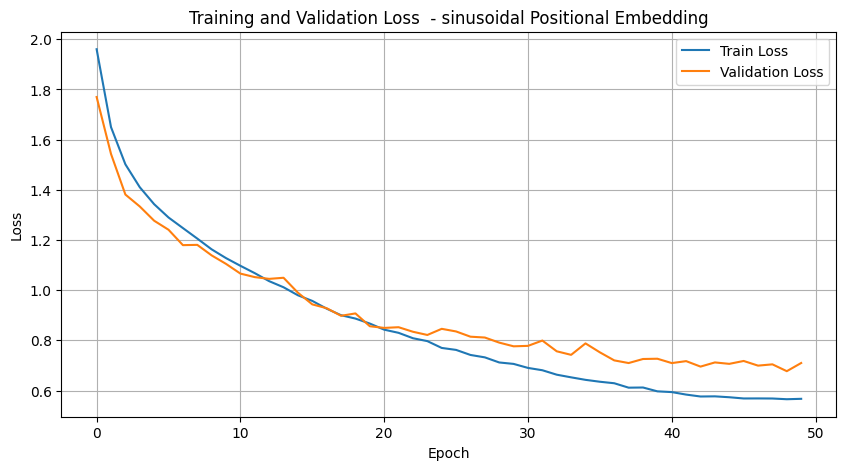

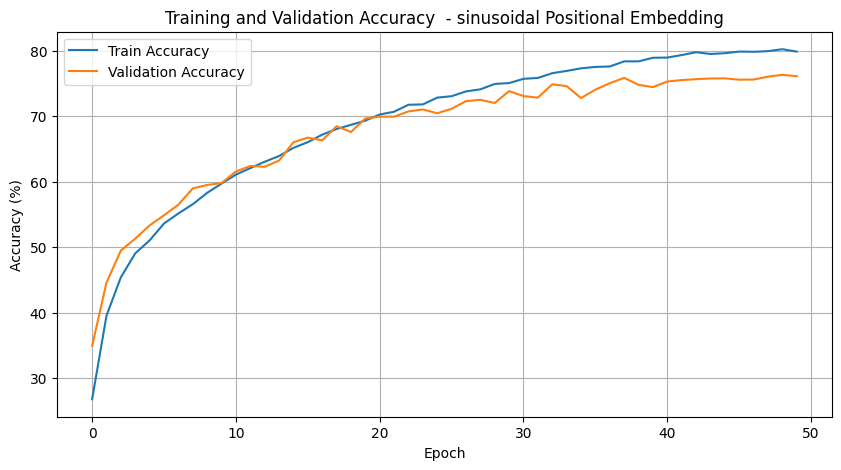



Positional Embedding Results Summary:
--------------------------------------------------
2d_learned     : 82.02%
1d_learned     : 81.23%
sinusoidal     : 81.06%
none           : 74.78%


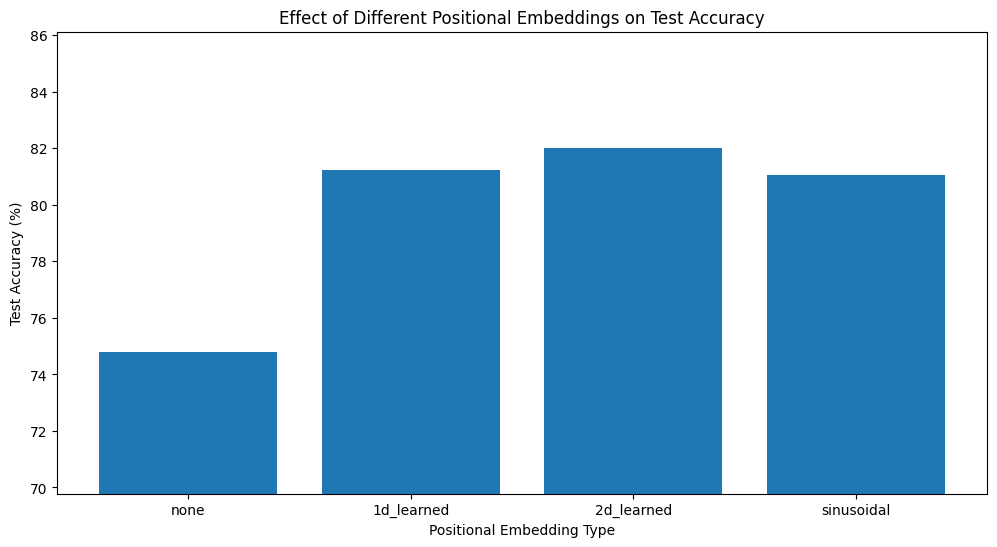

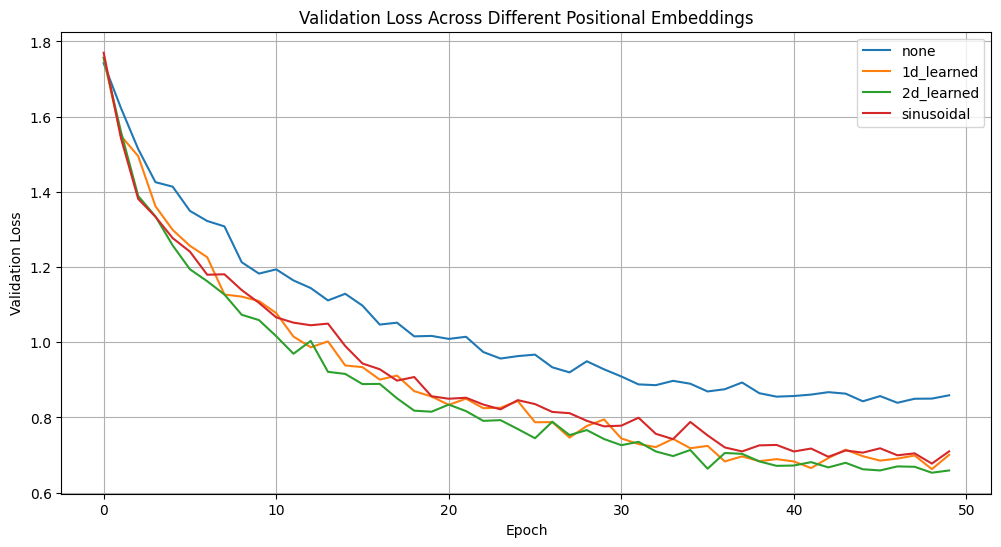

All done.


In [2]:


# Compare different positional embedding types
results = compare_positional_embeddings()
print("All done.")

## Comparison of Positional Embeddings based on loss curves

**2D Learned Embeddings** perform best because they directly model the image's two-dimensional structure, helping the model understand spatial relationships between patches.

**1D Learned Embeddings** work well but require the model to implicitly reconstruct 2D relationships from a flattened sequence.

**Sinusoidal Embeddings** underperform because they're fixed rather than learned, limiting adaptation to image-specific spatial patterns.

**No Positional Embeddings** performs worst as the model loses all spatial information, treating images as unordered "bags of patches."

The results confirm that position information is crucial for image understanding, with 2D-aware encodings providing the most benefit.